In [1]:
import gudhi as gd
import numpy as np
import matplotlib.pyplot as plt
import pywt
import tensorflow as tf
import pickle
import random as random

In [2]:
%load_ext tensorboard

**Create data set with circles in random positions**

In [3]:
def circle(center,radius):
    circ = np.vstack([radius*np.array([np.cos(theta),np.sin(theta)]) + center for theta in np.linspace(0,2*np.pi,30)])
    return circ

#truncate where it's zero, then round to next highest power of 2
def get_trunc_ind(arr):
    for i,_ in enumerate(arr):
        if np.all(arr[i:] == np.zeros(len(arr[i:]))):
            return int(2**(np.ceil(np.log(i)/np.log(2))))
    return len(arr)

def get_len_and_pos(ind,arr):
    #assume ind > 0
    n = np.log(len(arr))/np.log(2)
    wavelength = 2**(n-int((np.log(ind)/np.log(2))))
    pos = (ind-2**(int(np.log(ind)/np.log(2))))*wavelength
    return int(wavelength),int(pos)

def get_output(max_data,all_coeffs):
    coeff,ind = max_data
    if ind == 0:
        return coeff/np.sqrt(len(all_coeffs)),len(all_coeffs),0
    else:
        wl, pos = get_len_and_pos(ind,all_coeffs)
        return coeff/np.sqrt(wl),wl,pos
    
def convert_outputs(x):
    if x == 0:
        return 0
    else:
        return np.log(x)/np.log(2)
    
def pad_and_add(x,y):
    if len(x) >= len(y):
        y = np.pad(y,(0,len(x)-len(y)),'constant',constant_values=0)
    else:
        x = np.pad(x,(0,len(y)-len(x)),'constant',constant_values=0)
    return x + y

def plot_outputs(output1,output2,output3):
    func = np.zeros(1)
    out2 = np.round(output2)
    out3 = np.round(output3)
    for i,coeff in enumerate(output1[:-1]):
        wl = 2**int(np.round(output2[i]))
        
        temppos = int(np.round(output3[i]))
        if temppos == 0:
            pos = 0
        else:
            pos = 2**temppos
        
        to_add = np.hstack([np.zeros(pos),coeff*np.ones(wl//2),(-1)*coeff*np.ones(wl//2)])
        func = pad_and_add(func,to_add)
    func += output1[-1]
    return func
    

In [4]:
try:
    with open('outputs.p','rb') as f:
        outputs = pickle.load(f)
    
    with open('inputs.p','rb') as f:
        inputs = pickle.load(f)
    
except Exception as e:
    inputs = []
    outputs = []
    for i in range(0,2000):
        centers = np.random.random(size=(10,2))
        circle_pts = np.vstack([circle(center,0.5*np.random.random()) for center in centers])
        inputs.append(circle_pts)
        rc = gd.RipsComplex(circle_pts)
        st = rc.create_simplex_tree(max_dimension=2)
        st.persistence()
        temp = st.get_filtration()
        filtrants = sorted(set({x for _,x in temp}))

        betti_data = np.array([st.persistent_betti_numbers(start,end) for start,end in zip(filtrants[:-1],filtrants[1:])])
        trunced_arr = betti_data[:get_trunc_ind(betti_data[:,1]),1]

        coeffs = pywt.wavedec(trunced_arr,wavelet='db1',level=None)
        all_coeffs = np.hstack(coeffs)
        max_inds = np.argpartition(np.abs(all_coeffs),-10)[-10:]
        sorted_max_data = [(x,y) for x,y in sorted(list(zip(all_coeffs[max_inds],max_inds)))]
        output = np.array([get_output(x,all_coeffs) for x in sorted_max_data])
        #output = output/np.max(output,axis=0)
        #output = output.flatten()
        outputs.append(output)

In [ ]:
#with open('outputs.p','wb') as f:
#    pickle.dump(outputs,f)
    
#with open('inputs.p','wb') as f:
#    pickle.dump(inputs,f)

In [5]:
arr_inputs = np.array(inputs)

In [6]:
outputs1 = np.array([x[:,0] for x in outputs])
outputs2 = np.array([x[:,1] for x in outputs])
outputs3 = np.array([x[:,2] for x in outputs])

In [8]:
outputs2log = np.array([[convert_outputs(x) for x in arr] for arr in outputs2])
outputs3log = np.array([[convert_outputs(x) for x in arr] for arr in outputs3])

In [29]:
Input = tf.keras.layers.Input((300,2))

Stack1Start = tf.keras.layers.Flatten()(Input)
Stack1Dense = tf.keras.layers.Dense(40, activation='relu')(Stack1Start)
Stack1Drop = tf.keras.layers.Dropout(0.2)(Stack1Dense)
Stack1Dense2 = tf.keras.layers.Dense(20)(Stack1Drop)
Stack1Out = tf.keras.layers.Dense(10, activation='linear')(Stack1Dense2)

Stack2Start = tf.keras.layers.Flatten()(Input)
Stack2Dense = tf.keras.layers.Dense(40, activation='relu')(Stack2Start)
Stack2Drop = tf.keras.layers.Dropout(0.2)(Stack2Dense)
Stack2Dense2 = tf.keras.layers.Dense(20)(Stack2Drop)
Stack2Out = tf.keras.layers.Dense(10, activation='relu')(Stack2Dense2)

Stack3Start = tf.keras.layers.Flatten()(Input)
Stack3Dense = tf.keras.layers.Dense(40, activation='relu')(Stack3Start)
Stack3Drop = tf.keras.layers.Dropout(0.2)(Stack3Dense)
Stack3Dense2 = tf.keras.layers.Dense(20)(Stack3Drop)
Stack3Out = tf.keras.layers.Dense(10, activation='relu')(Stack3Dense2)

model = tf.keras.Model(inputs = Input, outputs = [Stack1Out,Stack2Out,Stack3Out])
model.compile(optimizer='adam',
              loss='mean_squared_error',
             )#metrics=['accuracy'])

In [36]:
logdir="logs/fit/"
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [38]:
model.fit(arr_inputs,[outputs1,outputs2log,outputs3log],epochs=100,callbacks=[tensorboard_callback])

Train on 2000 samples
Epoch 1/100
2000/2000 [==============================] - 0s 123us/sample - loss: 13.5251 - dense_17_loss: 1.4062 - dense_20_loss: 0.9415 - dense_23_loss: 11.1346
Epoch 2/100
2000/2000 [==============================] - 0s 82us/sample - loss: 13.5787 - dense_17_loss: 1.4135 - dense_20_loss: 0.9389 - dense_23_loss: 11.2060
Epoch 3/100
2000/2000 [==============================] - 0s 81us/sample - loss: 13.5554 - dense_17_loss: 1.4430 - dense_20_loss: 0.9371 - dense_23_loss: 11.1695
Epoch 4/100
2000/2000 [==============================] - 0s 79us/sample - loss: 13.5646 - dense_17_loss: 1.4242 - dense_20_loss: 0.9360 - dense_23_loss: 11.2016
Epoch 5/100
2000/2000 [==============================] - 0s 78us/sample - loss: 13.4689 - dense_17_loss: 1.4115 - dense_20_loss: 0.9387 - dense_23_loss: 11.1179
Epoch 6/100
2000/2000 [==============================] - 0s 82us/sample - loss: 13.6072 - dense_17_loss: 1.4060 - dense_20_loss: 0.9382 - dense_23_loss: 11.2664
Epoch 7/100

In [39]:
%tensorboard --logdir logs

In [19]:
model.predict(arr_inputs[0:1,:,:])

[array([[-5.0562468 , -3.3281987 , -2.3604817 ,  0.13362396,  1.4007106 ,
          1.9455361 ,  2.2949924 ,  2.752417  ,  3.0000482 ,  3.5831742 ]],
       dtype=float32),
 array([[10.380092,  9.931844,  9.375606,  9.984414, 10.7932  , 11.108236,
         11.887634, 12.998266, 13.768082, 13.852848]], dtype=float32),
 array([[ 9.0930969e-02,  1.4771514e+00,  7.3636351e+00,  9.8739452e+00,
          1.0168003e+01,  8.9604015e+00,  5.7258363e+00,  4.4029877e-01,
         -6.2023308e-03, -1.4372304e-02]], dtype=float32)]

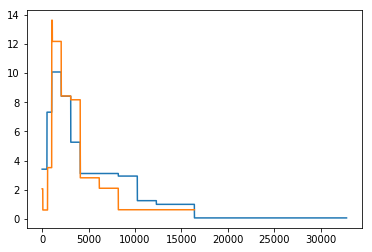

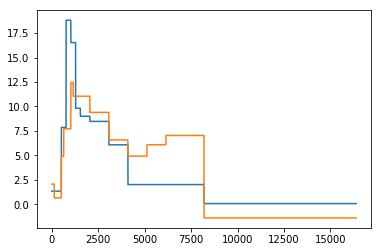

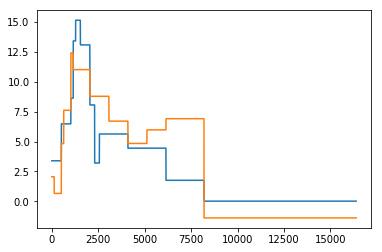

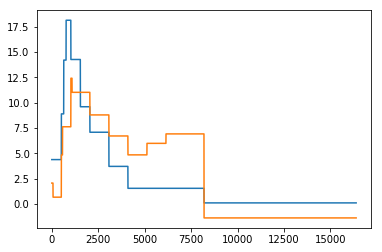

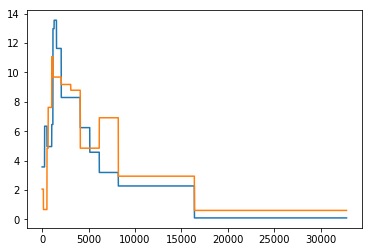

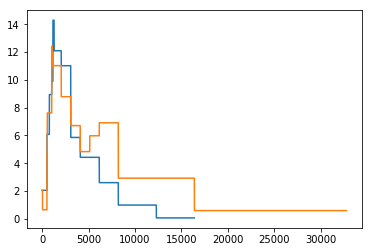

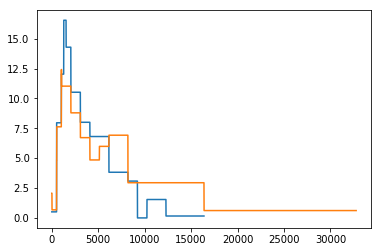

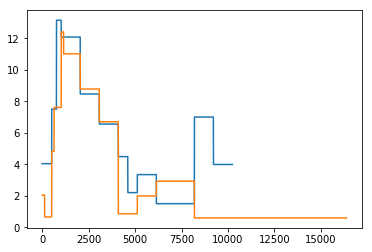

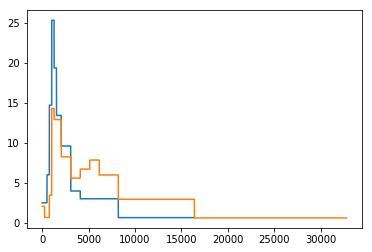

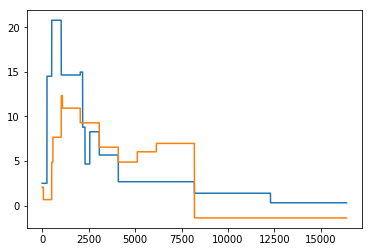

In [31]:
for i in range(30,40):
    plt.figure()
    plt.plot(plot_outputs(outputs1[i],outputs2log[i],outputs3log[i]))
    sample_input = arr_inputs[i:i+1][0]
    random.shuffle(sample_input)
    sample_input = np.expand_dims(sample_input,0)
    plt.plot(plot_outputs(*[x[0] for x in model.predict(sample_input)]))

In [32]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 300, 2)]     0                                            
__________________________________________________________________________________________________
flatten_6 (Flatten)             (None, 600)          0           input_3[0][0]                    
__________________________________________________________________________________________________
flatten_7 (Flatten)             (None, 600)          0           input_3[0][0]                    
__________________________________________________________________________________________________
flatten_8 (Flatten)             (None, 600)          0           input_3[0][0]                    
____________________________________________________________________________________________

In [ ]:
len_seq = len(all_coeffs)
func = np.zeros(len_seq)

for coeff,ind in sorted_max_data:
    if ind == 0:
        func += coeff/np.sqrt(len(all_coeffs))
    else:
        wl, pos = get_len_and_pos(ind,all_coeffs)
        normalizer = 1/np.sqrt(wl)
        func += np.hstack([np.zeros(pos),normalizer*coeff*np.ones(wl//2),normalizer*(-1)*coeff*np.ones(wl//2),np.zeros(len_seq -wl-pos)])

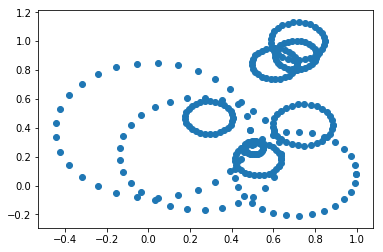

In [28]:
plt.scatter(inputs[9][:,0],inputs[9][:,1])